In [1]:
%pylab inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


# Task 1 - lens distortion

### Read files and preprocess data

In [2]:
# Load calibration data from file
with open('data/Calib.txt', 'r') as f:
    text_mat = f.read().split('\n\n')
cal_parameters = map(lambda x: np.fromstring(x, dtype=float, sep=' '), text_mat)

# intrinsic parameters
(a, c, b, u0, v0) = cal_parameters[0]
K = np.array([[a, c, u0],
              [0, b, v0],
              [0, 0, 1]])

# radial distortion parameters
(k1, k2) = cal_parameters[1]

# Rotation matricies for each image
def make_rotation_matrix(arr):
    arr = arr.reshape(4,3)
    M = np.zeros((3,4))
    M[:,:3] = arr[:3,:]
    M[:,3] = arr[3,:]
    return M
[R1, R2, R3, R4, R5] = map(make_rotation_matrix, cal_parameters[2:])

# model points
model = np.loadtxt('data/Model.txt')

# reference points
data_1 = np.loadtxt('data/data1.txt')
data_2 = np.loadtxt('data/data2.txt')
data_3 = np.loadtxt('data/data3.txt')
data_4 = np.loadtxt('data/data4.txt')
data_5 = np.loadtxt('data/data5.txt')

# distorted images
im_1 =imread('data/CalibIm1.gif')
im_2 =imread('data/CalibIm2.gif')
im_3 =imread('data/CalibIm3.gif')
im_4 =imread('data/CalibIm4.gif')
im_5 =imread('data/CalibIm5.gif')

# undistorted images
im_1_u = imread('data/UndistortIm1.gif')
im_2_u = imread('data/UndistortIm2.gif')

### Visualize distorted images and corners

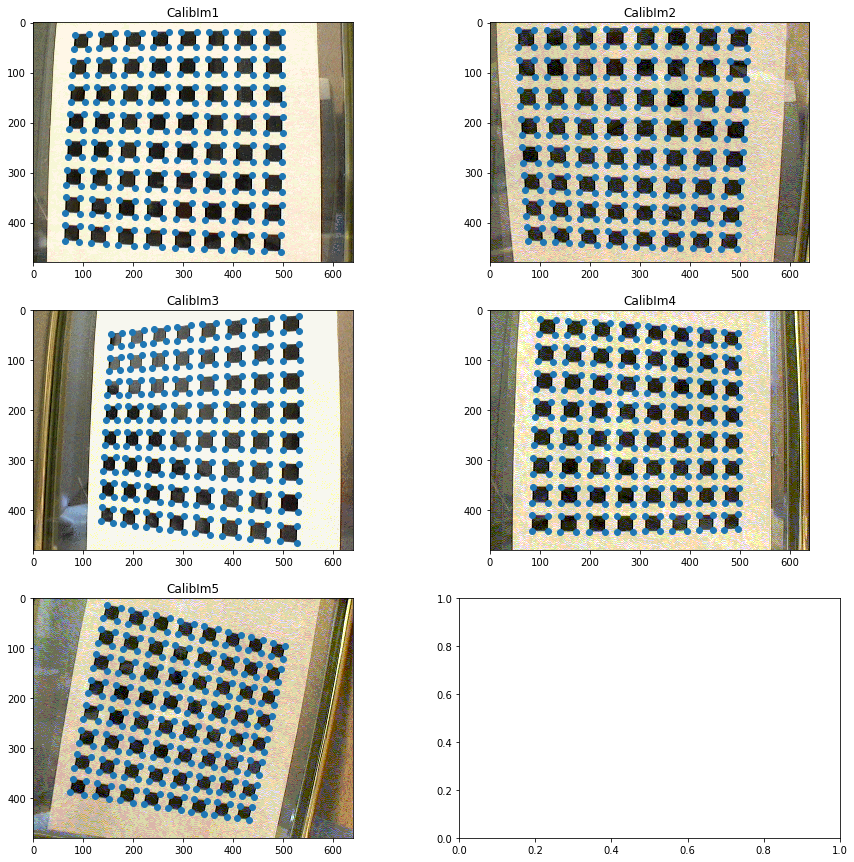

In [3]:
rcParams['figure.figsize'] = 15, 15
f, axs = plt.subplots(3, 2)
for i, (img, points) in enumerate(zip([im_1, im_2, im_3, im_4, im_5], [data_1, data_2, data_3, data_4, data_5])):
    axs[i/2, i%2].imshow(img)
    axs[i/2, i%2].scatter(points.reshape(64*4, 2)[:, 0], points.reshape(64*4, 2)[:, 1])
    axs[i/2, i%2].set_title('CalibIm{}'.format(i+1))

### Function for projecting points

In [4]:
def project(matrix, points):
    dim_y = points.shape[0]
    missing_columns = matrix.shape[1] - points.shape[1]
    if missing_columns == 2:
        points = np.hstack((points, np.zeros((dim_y, 1)), np.ones((dim_y, 1))))
    if missing_columns == 1:
        points = np.hstack((points, np.ones((dim_y, 1))))

    matrix = matrix[:, None, :]
    res = matrix.dot(points.T)[:, 0, :].T
    return res[:,:2] / res[:, 2, None]

In [5]:
def project_points(points, K, R, k1=None, k2=None):
    def radial_distortion(arr):
        xy2 = np.sum(arr**2, axis=1)
        term = (k1*xy2 + k2*xy2**2)
        new_x = arr[:, 0] * (1 + term)
        new_y = arr[:, 1] * (1 + term)
        return np.hstack((new_x[:, None], new_y[:,None]))

    dim_x = 2
    dim_y = points.shape[0] * points.shape[1]/dim_x
    
    points = points.reshape((dim_y, dim_x))
    res = project(R, points)
    
    if k1 is not None and k2 is not None:
        res = radial_distortion(res)
        
    return  project(K, res)

## Visualize model points on undistorted images

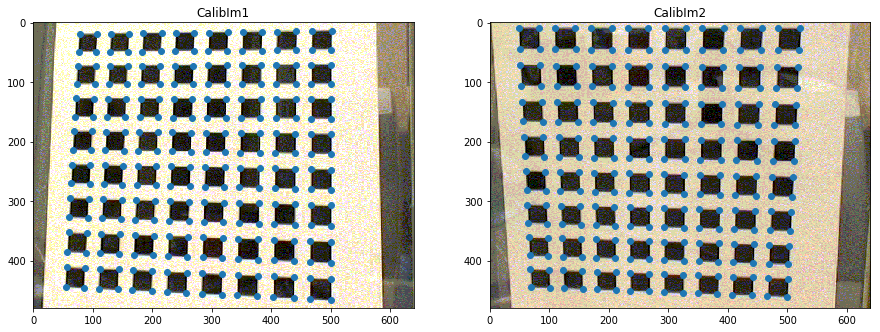

In [6]:
f, axs = plt.subplots(1, 2)
for i, (img, points) in enumerate(zip([im_1_u, im_2_u], [project_points(model, K, R1), project_points(model, K, R2)])):
    axs[i].imshow(img)
    axs[i].scatter(points[:, 0], points[:, 1])
    axs[i].set_title('CalibIm{}'.format(i+1))

## Visualize model points on distorted images

In [7]:
rcParams['figure.figsize'] = 18, 30
f, axs = plt.subplots(5, 3)
for i, (img, R) in enumerate(zip([im_1, im_2, im_3, im_4, im_5], [R1, R2, R3, R4, R5])):
    points1 = project_points(model, K, R)
    points2 = project_points(model, K, R, k1, k2)
    axs[i, 0].imshow(img)
    axs[i, 0].scatter(points1[:, 0], points1[:, 1], c='r')
    axs[i, 0].set_title('without distortion'.format(i+1))
    
    axs[i, 1].imshow(img)
    axs[i, 1].scatter(points2[:, 0], points2[:, 1], c='b')
    axs[i, 1].set_title('with distortion'.format(i+1))
    
    axs[i, 2].scatter(points1[:, 0], points1[:, 1], c='r')
    axs[i, 2].scatter(points2[:, 0], points2[:, 1], c='b')

In [8]:
for original, R in zip([data_1, data_2, data_3, data_4, data_5], [R1, R2, R3, R4, R5]):
    projected = project_points(model, K, R, k1, k2).reshape(original.shape)
    print np.linalg.norm(original - projected)

5.55768603917
3.70271270127
8.63964109099
3.77323015146
3.37660281937


# Task 2 - undistort image

In [9]:
from scipy.ndimage.interpolation import map_coordinates

In [10]:
def radial_distortion(arr):
    xy2 = np.sum(arr**2, axis=1)
    term = (k1*xy2 + k2*xy2**2)
    new_x = arr[:, 0] * (1 + term)
    new_y = arr[:, 1] * (1 + term)
    return np.hstack((new_x[:, None], new_y[:,None]))

In [11]:
x,y = np.meshgrid(np.arange(im_1.shape[0]), np.arange(im_1.shape[1]))
coords = np.stack((x,y), axis=2).reshape((-1,2), order='F')

In [12]:
c = coords.reshape((480,640,2))
c2 = project(K, radial_distortion(project(np.linalg.inv(K), coords))).reshape((480,640,2))

### Basicly we want to "take" the point (blue) from oryginal image and put it in the right pixel (red)

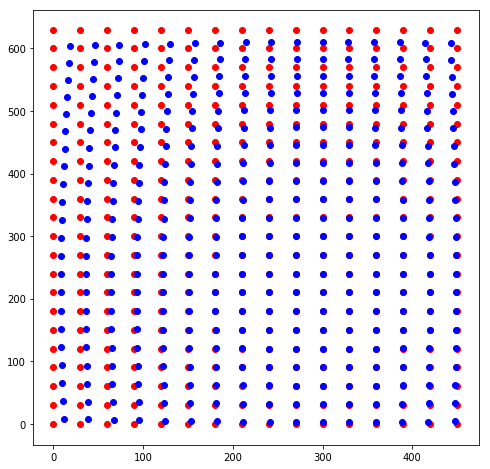

In [13]:
rcParams['figure.figsize'] = 8, 8
f, axs = plt.subplots(1, 1)
axs.scatter(c[::30, ::30, 0], c[::30,::30, 1], c='r')
axs.scatter(c2[::30, ::30, 0], c2[::30,::30, 1], c='b')

In [14]:
def undistort_image(img, K, k1, k2):
    def radial_distortion(arr):
        xy2 = np.sum(arr**2, axis=1)
        term = (k1*xy2 + k2*xy2**2)
        new_x = arr[:, 0] * (1 + term)
        new_y = arr[:, 1] * (1 + term)
        return np.hstack((new_x[:, None], new_y[:,None]))
    
    x,y = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]))
    coords = np.stack((x,y), axis=2).reshape((-1,2), order='F')
    
    distorted = np.fliplr(project(K, radial_distortion(project(np.linalg.inv(K), np.fliplr(coords)))))

    distorted_r = np.hstack((distorted, 2*np.ones((distorted.shape[0], 1))))
    distorted_g = np.hstack((distorted, np.ones((distorted.shape[0], 1))))
    distorted_b = np.hstack((distorted, np.zeros((distorted.shape[0], 1))))
    distorted_a = np.hstack((distorted, 3*np.ones((distorted.shape[0], 1))))
    
    pts_r = map_coordinates(img, distorted_r.T, order=3)
    pts_g = map_coordinates(img, distorted_g.T, order=3)
    pts_b = map_coordinates(img, distorted_b.T, order=3)
    pts_a = map_coordinates(img, distorted_a.T, order=3)
    
    pts = np.vstack((pts_b, pts_g, pts_r, pts_a)).T
    pts = pts.reshape(img.transpose(1,0,2).shape, order='F').transpose((1,0,2))
    
    return pts

In [15]:
rcParams['figure.figsize'] = 20, 35
f, axs = plt.subplots(5, 2)
for i, (img, R) in enumerate(zip([im_1, im_2, im_3, im_4, im_5], [R1, R2, R3, R4, R5])):
    points1 = project_points(model, K, R)
    points2 = project_points(model, K, R, k1, k2)
    im_und = undistort_image(img, K, k1, k2)
    
    axs[i, 0].imshow(img)
    axs[i, 0].scatter(points2[:, 0], points2[:, 1], c='r')
    axs[i, 0].set_title('with distortion'.format(i+1))
    
    axs[i, 1].imshow(im_und)
    axs[i, 1].scatter(points1[:, 0], points1[:, 1], c='b')
    axs[i, 1].set_title('without distortion'.format(i+1))

# Task 3 - estimation of radial distortion parameters

distorted  = K * d(R*model)
d(x) = x + x * (k1*xy2 + k2*xy4)

In [51]:
distorted_points = np.vstack([d.reshape((64*4,2)) for d in [data_1, data_2, data_3, data_4, data_5]]) # u' v'
normalized_points = np.vstack([project(R, model.reshape((64*4, 2))) for R in [R1, R2, R3, R4, R5]]) # u v
undistorted_points = np.vstack([project_points(model, K, R) for R in [R1, R2, R3, R4, R5]]) # u v

In [52]:
D = np.zeros((2*5*64*4, 2))
d = np.zeros((2*5*64*4, 1))

u_u0 = undistorted_points[:, 0] - u0
v_v0 = undistorted_points[:, 1] - v0

xy2 = np.sum(normalized_points**2, axis=1)

D[::2, 0] = u_u0 * xy2 
D[::2, 1] = u_u0 * xy2**2 
D[1::2, 0] = v_v0 * xy2 
D[1::2, 1] = v_v0 * xy2**2

d[::2, 0] = distorted_points[:, 0] - undistorted_points[:, 0]
d[1::2, 0] = distorted_points[:, 1] - undistorted_points[:, 1]


In [53]:
print k1, k2

-0.228601 0.190353


In [54]:
k3, k4 = np.linalg.lstsq(D, d[:,0])[0]
print k3, k4

-0.228579291845 0.190207838844


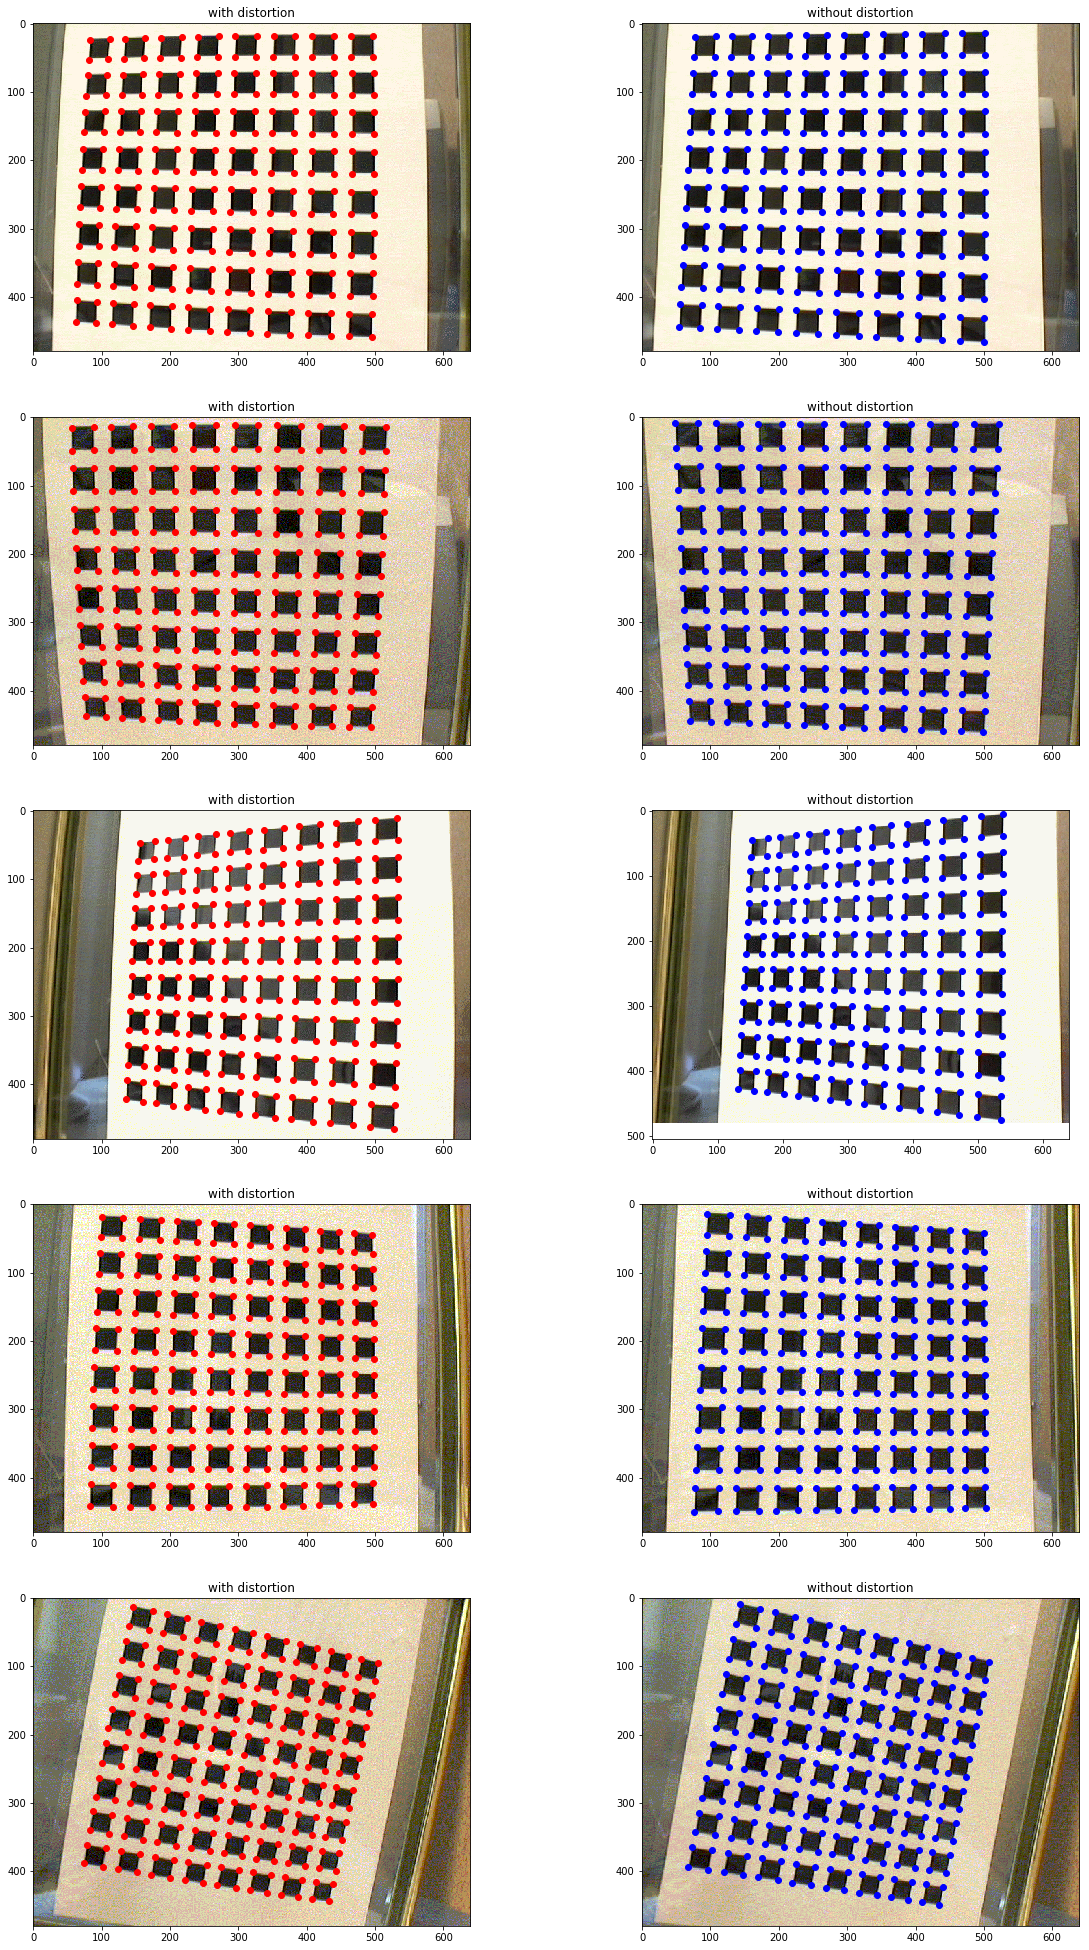

In [50]:
rcParams['figure.figsize'] = 20, 35
f, axs = plt.subplots(5, 2)
for i, (img, R) in enumerate(zip([im_1, im_2, im_3, im_4, im_5], [R1, R2, R3, R4, R5])):
    points1 = project_points(model, K, R)
    points2 = project_points(model, K, R, k3, k4)
    im_und = undistort_image(img, K, k3, k4)
    
    axs[i, 0].imshow(img)
    axs[i, 0].scatter(points2[:, 0], points2[:, 1], c='r')
    axs[i, 0].set_title('with distortion'.format(i+1))
    
    axs[i, 1].imshow(im_und)
    axs[i, 1].scatter(points1[:, 0], points1[:, 1], c='b')
    axs[i, 1].set_title('without distortion'.format(i+1))